<a href="https://colab.research.google.com/github/fikahernindiya/fika-hernindiya_TA_LSTM-Attention/blob/main/LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Permute, Multiply, Lambda, Softmax

2025-07-23 09:08:33.691976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753236513.715444   10934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753236513.722610   10934 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 09:08:33.749586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
seed_value = 7
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
csv_path = '/home/jetson/data.csv'
df = pd.read_csv(csv_path)
print("Data loaded! Number of rows:", len(df))

Data loaded! Number of rows: 50400


In [ ]:
data_target = df['bus_voltage'].values.reshape(-1, 1)

data_min = data_target.min()
data_max = data_target.max()
data_scaled = (data_target - data_min) / (data_max - data_min + 1e-8)

In [ ]:
WINDOW_SIZE = 10
FUTURE_STEP = 1

X, y = [], []
for i in range(len(data_scaled) - WINDOW_SIZE - FUTURE_STEP + 1):
    X.append(data_scaled[i:i+WINDOW_SIZE, 0])
    y.append(data_scaled[i+WINDOW_SIZE:i+WINDOW_SIZE+FUTURE_STEP, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"Sliding window done! X shape: {X.shape}, y shape: {y.shape}")

Sliding window done! X shape: (50390, 10, 1), y shape: (50390, 1)


In [ ]:
total_samples = len(X)
train_end = int(0.7 * total_samples)
val_end = int(0.85 * total_samples)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 35273, Validation size: 7558, Test size: 7559


In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.attention_dense = tf.keras.layers.Dense(1, activation='tanh')
        self.softmax = tf.keras.layers.Softmax(axis=1)

    def call(self, inputs):
        attention_scores = self.attention_dense(inputs)
        attention_weights = self.softmax(attention_scores)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

In [ ]:
input_layer = Input(shape=(WINDOW_SIZE, 1))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = AttentionLayer()(lstm_out)
output_layer = Dense(FUTURE_STEP)(attention_out)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse')
model.summary()

plot_model(model, to_file='model_architecture_lstm_attention.png', show_shapes=True, show_layer_names=True)
print("Model architecture saved to 'model_architecture_lstm_attention.png'")

I0000 00:00:1753236517.726304   10934 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2154 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,026 (66.51 KB)

 Trainable params: 17,026 (66.51 KB)

 Non-trainable params: 0 (0.00 B)

Model architecture saved to 'model_architecture_lstm_attention.png'


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10


I0000 00:00:1753236521.115555   11016 cuda_dnn.cc:529] Loaded cuDNN version 90701


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0152 - val_loss: 0.0017
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012 - val_loss: 8.6481e-04
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 9.7995e-04 - val_loss: 4.3291e-04
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.7250e-04 - val_loss: 3.9278e-04
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.0094e-04 - val_loss: 2.1448e-04
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.7289e-04 - val_loss: 2.2069e-04
Epoch 9/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.6228e-04 - val_loss: 2.2456e-04
Epoch 10/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.5521e-04 - val_loss: 2.1535e-04


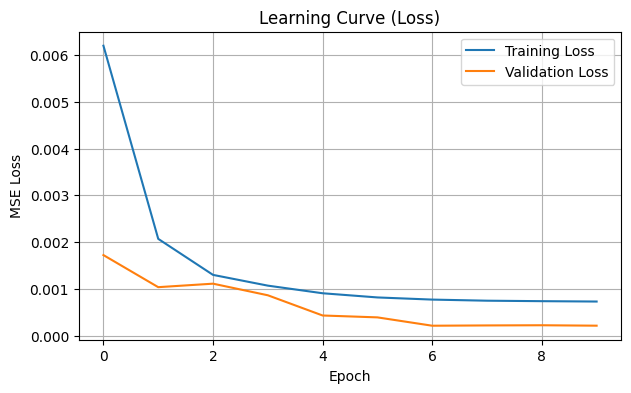

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_val_pred = model.predict(X_val)

y_val_pred_inv = y_val_pred * (data_max - data_min) + data_min
y_val_inv = y_val * (data_max - data_min) + data_min

y_val_pred_inv = y_val_pred_inv[:, 0]
y_val_inv = y_val_inv[:, 0]

print("Sample (Validation)")
print("Predicted values:", y_val_pred_inv[:5])
print("Actual values:", y_val_inv[:5])

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample (Validation)
Predicted values: [14.02982546 14.07882643 14.12795251 14.17691596 14.23485804]
Actual values: [14.13999999 14.18999999 14.23999999 14.29999999 14.34999999]


In [ ]:
y_test_pred = model.predict(X_test)
y_test_pred_inv = y_test_pred * (data_max - data_min) + data_min
y_test_inv = y_test * (data_max - data_min) + data_min

y_test_pred_inv = y_test_pred_inv[:, 0]
y_test_inv = y_test_inv[:, 0]

print("Sample (Testing)")
print("Predicted values:", y_test_pred_inv[:5])
print("Actual values:", y_test_inv[:5])

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample (Testing)
Predicted values: [4.49961781 5.00308984 5.50390184 5.99541619 6.49831163]
Actual values: [5.01 5.51 6.   6.5  7.  ]


In [ ]:
index_val_ori = train_end + WINDOW_SIZE + np.arange(len(y_val))

df_val = pd.DataFrame({
    'No': np.arange(1, len(y_val_inv) + 1),
    'Indices': index_val_ori,
    'Actual values': np.round(y_val_inv, 7),
    'Predicted values': np.round(y_val_pred_inv, 8)
})
df_val['Error'] = np.abs(df_val['Actual values'] - df_val['Predicted values'])

total_error_val = df_val['Error'].sum()
print('\nTotal Error (Validation):', total_error_val)


Total Error (Validation): 856.7153437400001


In [ ]:
index_test_ori = val_end + WINDOW_SIZE + np.arange(len(y_test))

df_result = pd.DataFrame({
    'No': np.arange(1, len(y_test_inv) + 1),
    'Indices': index_test_ori,
    'Actual values': np.round(y_test_inv, 7),
    'Predicted values': np.round(y_test_pred_inv, 8)
})
df_result['Error'] = np.abs(df_result['Actual values'] - df_result['Predicted values'])

total_error = df_result['Error'].sum()
print('\nTotal Error (Testing):', total_error)


Total Error (Testing): 864.0883735


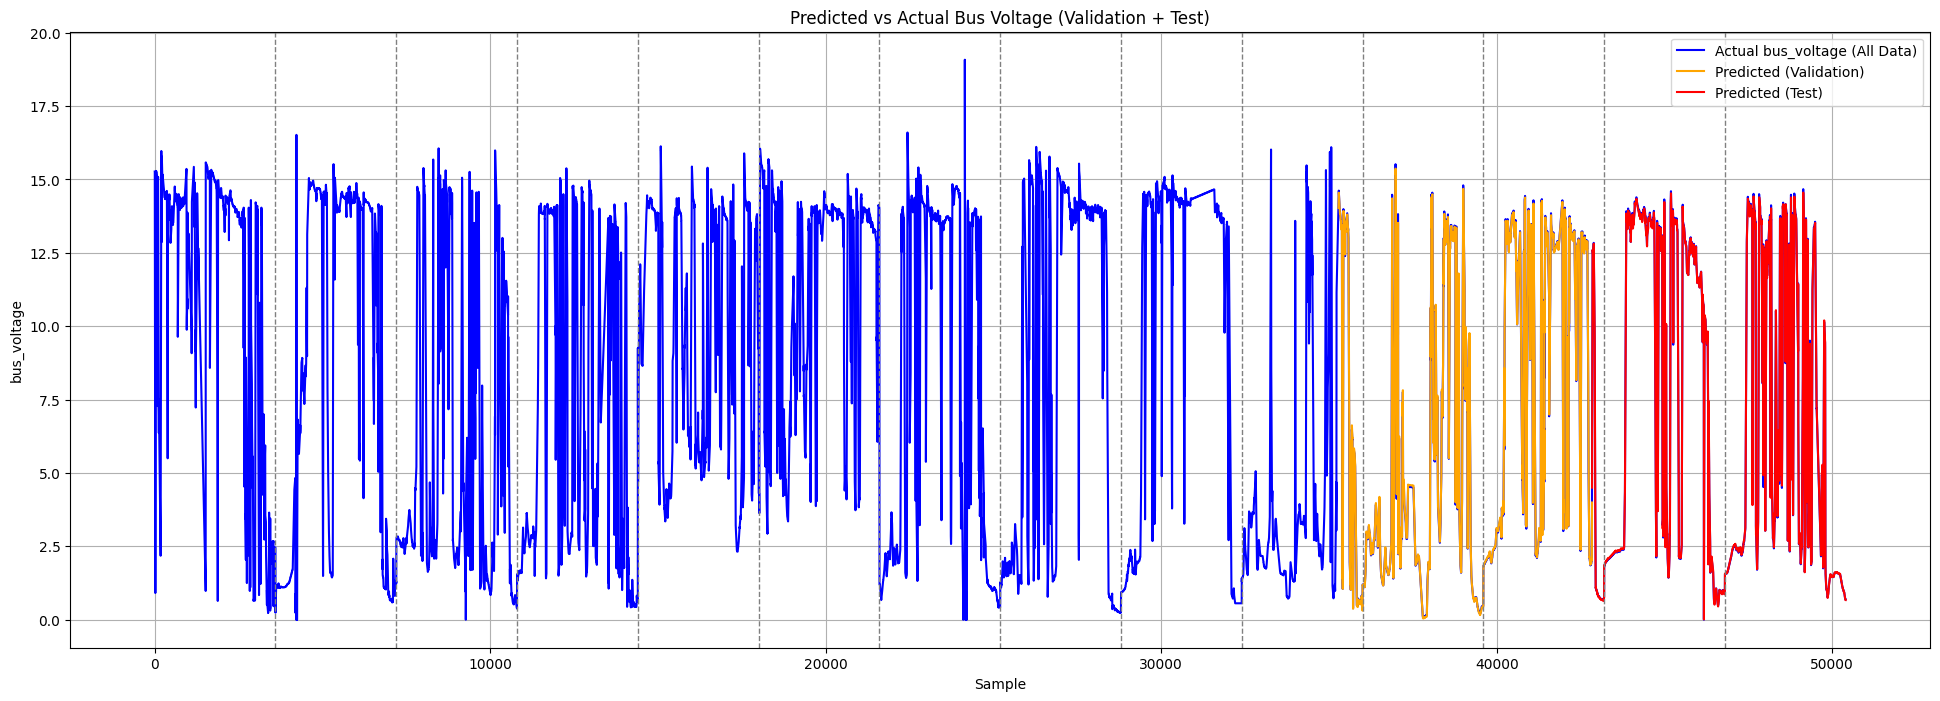

In [ ]:
predicted_full = np.full(df.shape[0], np.nan)

plt.figure(figsize=(24, 8))
plt.plot(df['bus_voltage'].values, label='Actual bus_voltage (All Data)', color='blue')
plt.plot(index_val_ori, y_val_pred_inv, color='orange', label='Predicted (Validation)')
plt.plot(index_test_ori, y_test_pred_inv, color='red', label='Predicted (Test)')

interval = 3600
n = len(df['bus_voltage'])
for i in range(interval, n, interval):
    plt.axvline(i, color='gray', linestyle='--', linewidth=1)

plt.title('Predicted vs Actual Bus Voltage (Validation + Test)')
plt.xlabel('Sample')
plt.ylabel('bus_voltage')
plt.legend()
plt.grid(True)
plt.show()

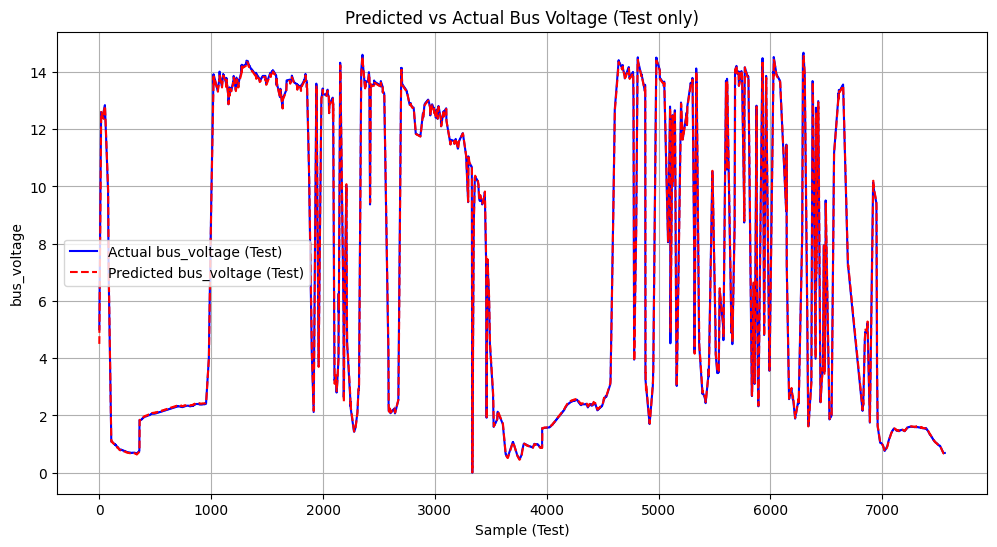

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual bus_voltage (Test)', color='blue')
plt.plot(y_test_pred_inv, label='Predicted bus_voltage (Test)', color='red', linestyle='--')
n_test = len(y_test_inv)
plt.title('Predicted vs Actual Bus Voltage (Test only)')
plt.xlabel('Sample (Test)')
plt.ylabel('bus_voltage')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mae = total_error / len(df_result)
print(f"MAE: {mae:.6f}")

MAE: 0.114313


In [ ]:
df_result.to_csv('predict_lstm_attention.csv', index=False)
print('Successfully saved as predict_lstm_attention.csv')

Successfully saved as predict_lstm_attention.csv
